In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('./Named Storm Data - since 1950.csv')
print('Glance of the entire data')
print('\n')
df.info()

Glance of the entire data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  808 non-null    int64  
 1   Storm Name            808 non-null    object 
 2   Start Date            808 non-null    object 
 3   End Date              808 non-null    object 
 4   Dates                 808 non-null    object 
 5   Max Wind Speed (mph)  808 non-null    int64  
 6   Min pressure (mb)     797 non-null    float64
 7   Storm Type            808 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 50.6+ KB


In [ ]:
start_date_parsed = pd.to_datetime(df['Start Date'], format='%m/%d/%y', errors='coerce')
month_day = start_date_parsed.dt.strftime('%m-%d')
full_date_str = df['Year'].astype(str) + '-' + month_day
df['Corrected Start Date'] = pd.to_datetime(full_date_str, errors='coerce')
df = df.dropna(subset=['Corrected Start Date'])
df['Month'] = df['Corrected Start Date'].dt.to_period('M').astype(str)
df_monthly_counts = df.groupby('Month').size().reset_index(name='Storm Count')
min_date = df['Corrected Start Date'].min()
max_date = df['Corrected Start Date'].max()

all_months = pd.date_range(start=min_date.replace(day=1),end=max_date.replace(day=1),freq='MS').to_period('M').astype(str)
all_months_df = pd.DataFrame({'Month': all_months})
df_monthly_counts = pd.merge(all_months_df,df_monthly_counts,on='Month',how='left').fillna(0)
df_monthly_counts['Storm Count'] = df_monthly_counts['Storm Count'].astype(int)
df_monthly_counts = df_monthly_counts.sort_values('Month').reset_index(drop=True)
print(df_monthly_counts)

       Month  Storm Count
0    1950-08            4
1    1950-09            3
2    1950-10            6
3    1950-11            0
4    1950-12            0
..       ...          ...
863  2022-07            1
864  2022-08            1
865  2022-09            7
866  2022-10            4
867  2022-11            2

[868 rows x 2 columns]


In [ ]:
df_monthly_counts.head()

,Month,Storm Count
0,1950-08,4
1,1950-09,3
2,1950-10,6
3,1950-11,0
4,1950-12,0


In [ ]:
df_monthly_counts.dtypes

,0
Month,object
Storm Count,int64


In [ ]:
df_monthly_counts.head()

,Month,Storm Count
0,1950-08,4
1,1950-09,3
2,1950-10,6
3,1950-11,0
4,1950-12,0


In [ ]:
df_monthly_counts.dtypes

,0
Month,object
Storm Count,int64


In [ ]:
dt = pd.to_datetime(df_monthly_counts['Month'], format='%Y-%m')
df_monthly_counts['Year'] = dt.dt.year
df_monthly_counts['MonthNum'] = dt.dt.month
df_monthly_counts = df_monthly_counts[(df_monthly_counts['Year']>=2010)]
pivot_df = df_monthly_counts.pivot(index='MonthNum', columns='Year', values='Storm Count').fillna(0)

In [ ]:
print(df_monthly_counts.shape)
df_monthly_counts = df_monthly_counts[(df_monthly_counts['Year']>=2010)]
print(df_monthly_counts.shape)

(155, 4)
(155, 4)


In [ ]:
df_monthly_counts.columns

Index(['Month', 'Storm Count', 'Year', 'MonthNum'], dtype='object')

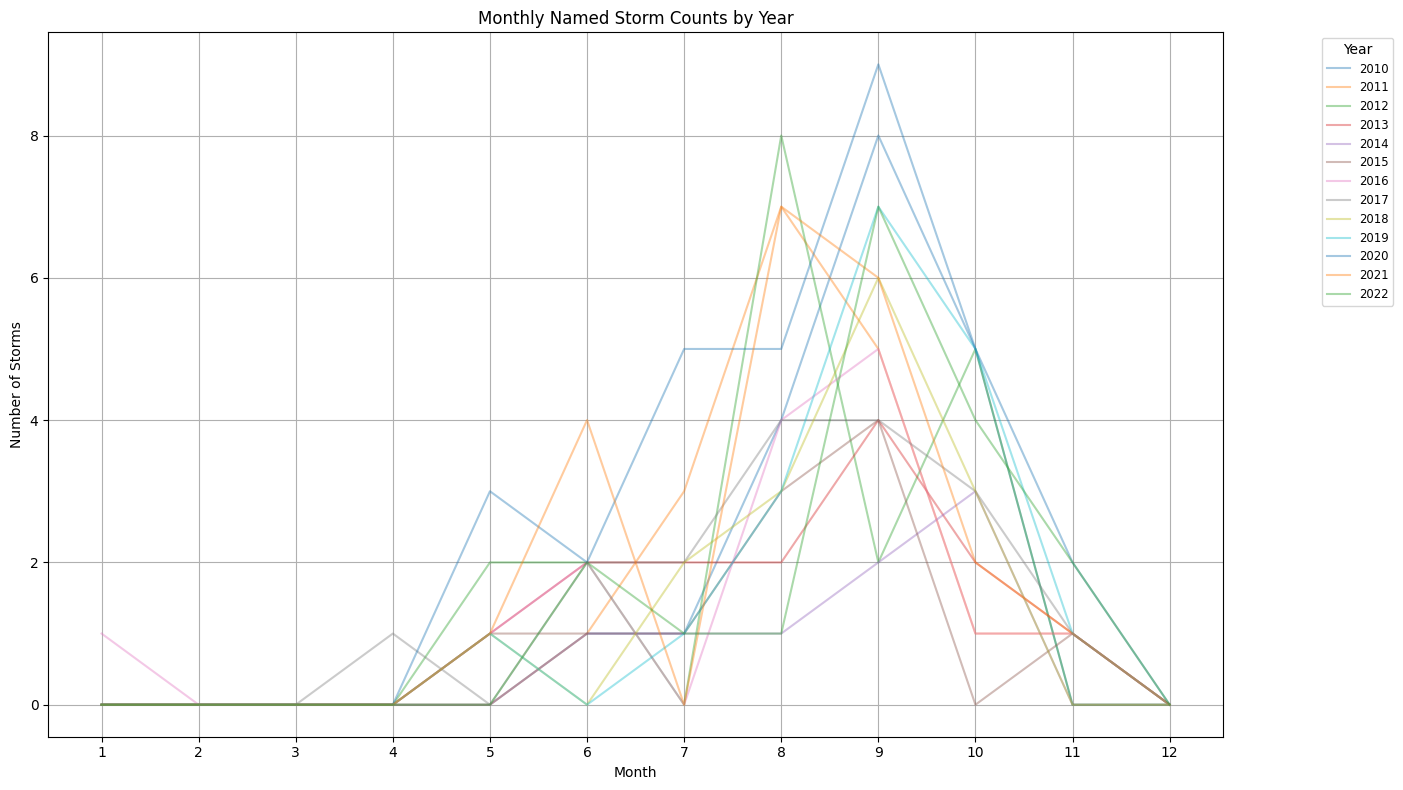

In [ ]:
plt.figure(figsize=(14, 8))
for year in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[year], label=str(year), alpha=0.4)
plt.title('Monthly Named Storm Counts by Year')
plt.xlabel('Month')
plt.ylabel('Number of Storms')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Year", fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
print(df_monthly_counts.shape)

(155, 4)


In [ ]:
df['Month'].value_counts()

,count
Month,
2020-09,9
2012-08,8
2010-09,8
2002-09,8
2007-09,7
...,...
2022-08,1
2021-11,1
1954-06,1


In [ ]:
df_monthly_counts['Month'] = pd.to_datetime(df_monthly_counts['Month'], format='%Y-%m')
df_monthly_counts = df_monthly_counts.set_index('Month')
print(df_monthly_counts.head())
df_monthly_counts = df_monthly_counts[['Storm Count']]
print(df_monthly_counts.head())

            Storm Count  Year  MonthNum
Month                                  
2010-01-01            0  2010         1
2010-02-01            0  2010         2
2010-03-01            0  2010         3
2010-04-01            0  2010         4
2010-05-01            0  2010         5
            Storm Count
Month                  
2010-01-01            0
2010-02-01            0
2010-03-01            0
2010-04-01            0
2010-05-01            0


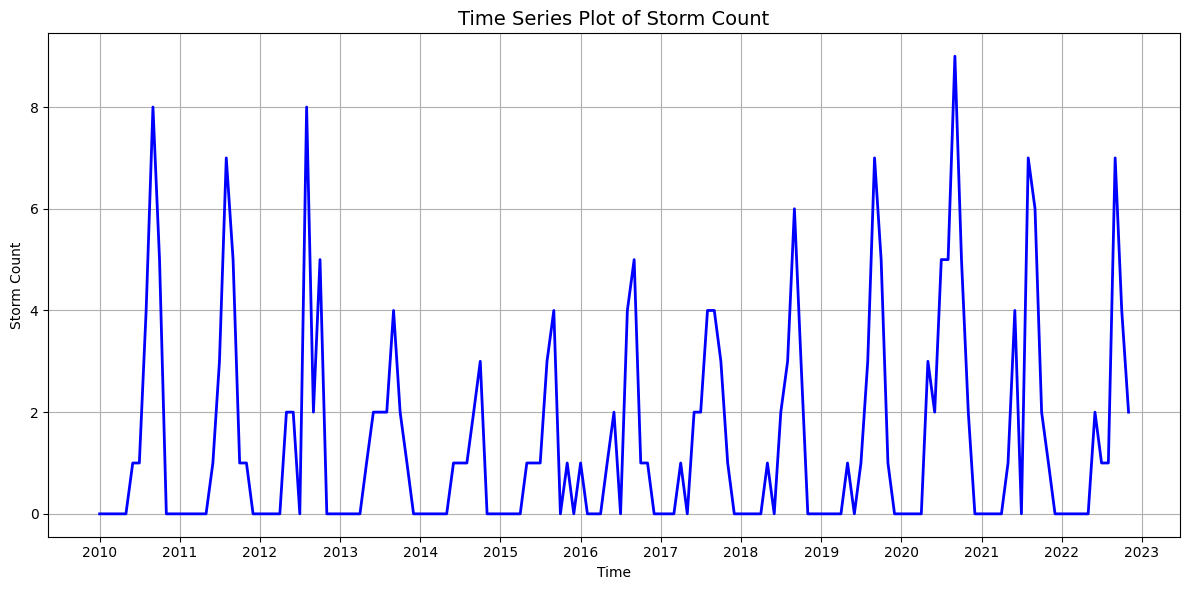

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_counts.index, df_monthly_counts['Storm Count'], color='blue', linewidth=2)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Time Series Plot of Storm Count', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Storm Count')
plt.grid(True)
plt.tight_layout()
plt.show()

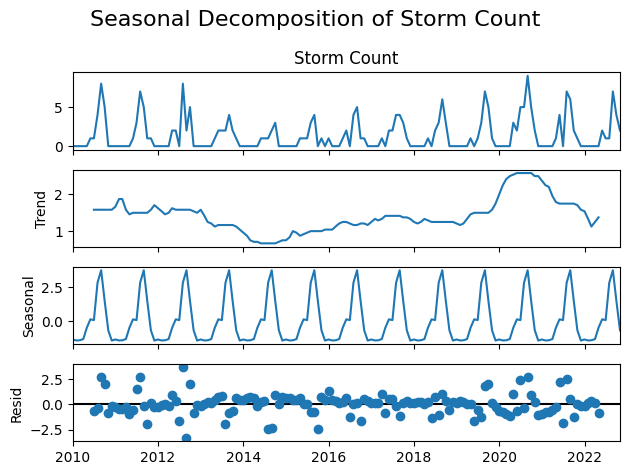

In [ ]:
ts = df_monthly_counts['Storm Count'].dropna()
decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Storm Count', fontsize=16)
plt.tight_layout()
plt.show()

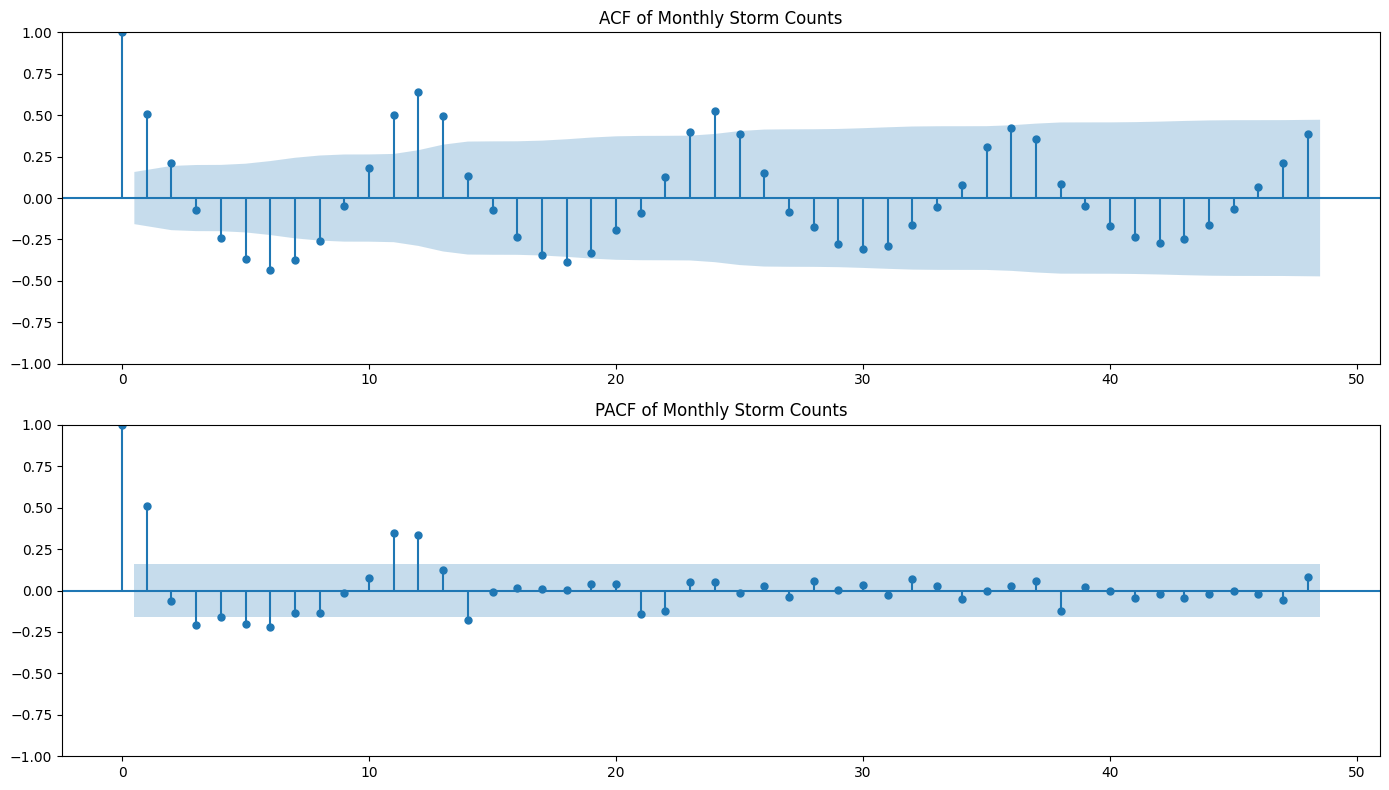

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(211)
plot_acf(df_monthly_counts, ax=plt.gca(), lags=48, alpha=0.05)  # 95% CI
plt.title('ACF of Monthly Storm Counts')

plt.subplot(212)
plot_pacf(df_monthly_counts, ax=plt.gca(), lags=48, method='ywm', alpha=0.05)
plt.title('PACF of Monthly Storm Counts')

plt.tight_layout()
plt.show()

In [ ]:
df_monthly_counts.shape

(155, 1)

In [ ]:
print('Augmented Dickey-Fuller (ADF) Test')
adf = adfuller(df_monthly_counts)
print(f'ADF Test Statistic: {adf[0]:.4f}')
print(f'p value: {adf[1]:.4f}')
if adf[1] < 0.05:
    print("\n Reject the null hypothesis,the data is stationary")
else:
    print("\n Fail to reject the null,the data is not stationary")

Augmented Dickey-Fuller (ADF) Test
ADF Test Statistic: -1.6445
p value: 0.4599

 Fail to reject the null,the data is not stationary


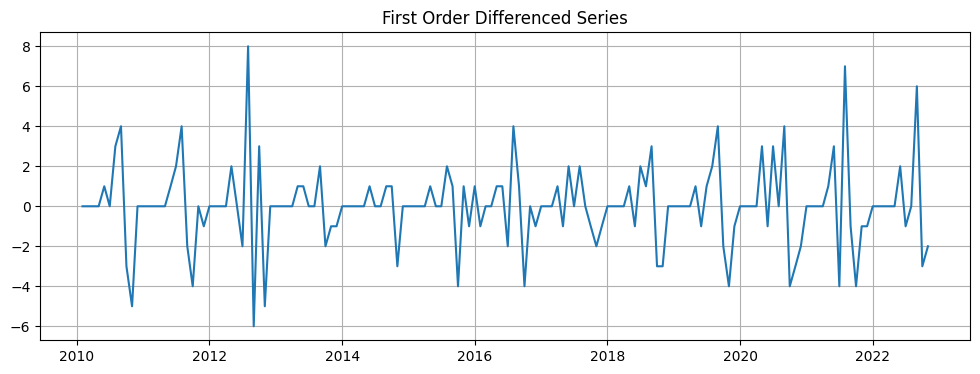

(154, 1)


In [ ]:
differencing = df_monthly_counts.diff(1).dropna()
plt.figure(figsize=(12, 4))
plt.plot(differencing)
plt.title("First Order Differenced Series")
plt.grid(True)
plt.show()
print(differencing.shape)

In [ ]:
print('ADF Test on First Differenced Series:')
adf_differecing = adfuller(differencing)
print(f"ADF Statistic: {adf_differecing[0]}")
print(f"p-value: {adf_differecing[1]}")
if adf_differecing[1] < 0.05:
    print("\n Reject the null hypothesis,the data is stationary")
else:
    print("\n Fail to reject the null,the data is not stationary")

ADF Test on First Differenced Series:
ADF Statistic: -6.6073226742066025
p-value: 6.507240026478501e-09

 Reject the null hypothesis,the data is stationary


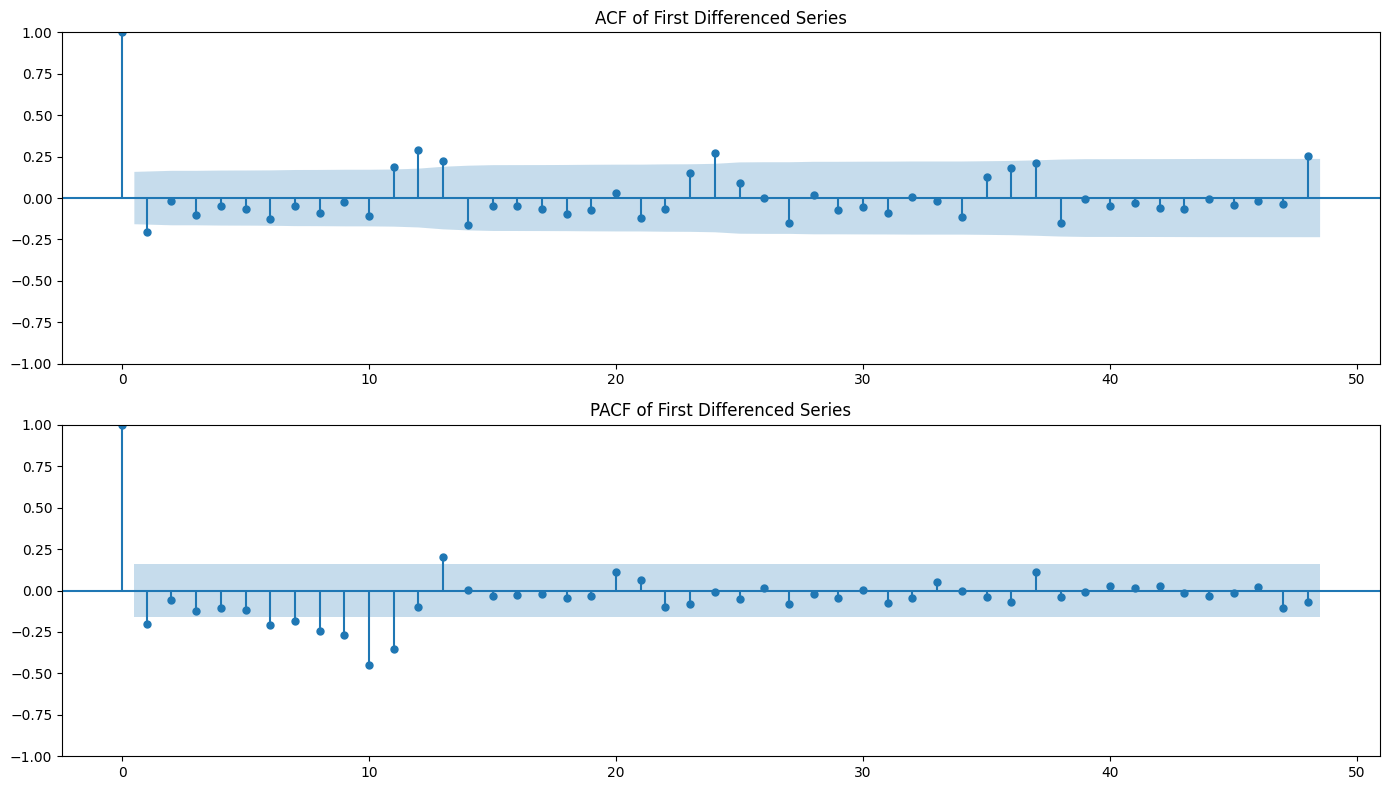

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
plot_acf(differencing, ax=plt.gca(), lags=48)
plt.title('ACF of First Differenced Series')
plt.subplot(212)
plot_pacf(differencing, ax=plt.gca(), lags=48, method='ywm')
plt.title('PACF of First Differenced Series')
plt.tight_layout()
plt.show()

In [ ]:
pnc = differencing.dropna()
a = b = c = range(3)
x = y = z = range(2)
s = 12
res = []
for p in a:
    for d in b:
        for q in c:
            for P in x:
                for D in y:
                    for Q in z:
                            m = SARIMAX(pnc, order=(p, d, q), seasonal_order=(P, D, Q, s),enforce_stationarity=False, enforce_invertibility=False)
                            r = m.fit(disp=0)
                            res.append({'ord': (p, d, q), 's_ord': (P, D, Q, s), 'AIC': r.aic, 'BIC': r.bic})
df = pd.DataFrame(res).sort_values('AIC').reset_index(drop=True)
print(df.head(6))

         ord          s_ord         AIC         BIC
0  (2, 0, 2)  (0, 1, 1, 12)  433.039188  450.104311
1  (2, 0, 1)  (0, 1, 1, 12)  433.291369  447.551520
2  (1, 0, 2)  (0, 1, 1, 12)  434.847923  449.068858
3  (2, 0, 2)  (1, 1, 1, 12)  435.015219  454.924528
4  (0, 0, 2)  (0, 1, 1, 12)  435.106966  446.483714
5  (2, 1, 2)  (0, 1, 1, 12)  435.331663  452.349355


In [ ]:
ts_data = differencing.dropna()
model_sarima = SARIMAX(ts_data, order=(2, 0, 2), seasonal_order=(0,1,1, 12))
results_sarima = model_sarima.fit()

In [ ]:
print(f"AIC : {results_sarima.aic}")
print(f"BIC : {results_sarima.bic}")

AIC : 494.63781716549715
BIC : 512.3727795111047


In [ ]:
resid = results_sarima.filter_results.standardized_forecasts_error[0]
resid = pd.Series(resid).dropna()

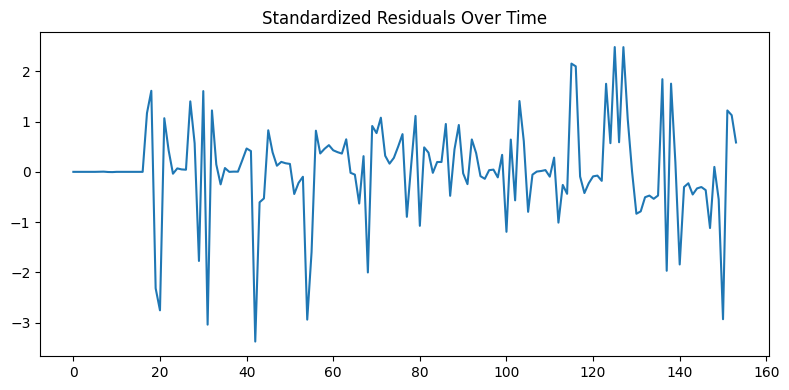

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(resid)
ax1.set_title('Standardized Residuals Over Time')
plt.tight_layout()
plt.show()

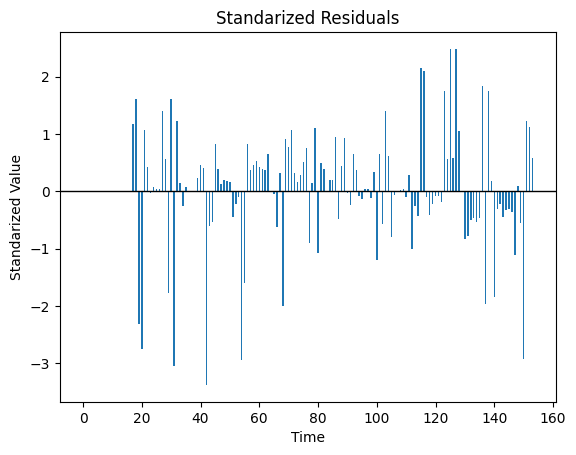

In [ ]:
plt.bar(range(len(resid)), resid, width=0.5)
plt.axhline(0, color='black', linewidth=1)
plt.title('Standarized Residuals')
plt.xlabel('Time')
plt.ylabel('Standarized Value')
plt.show()

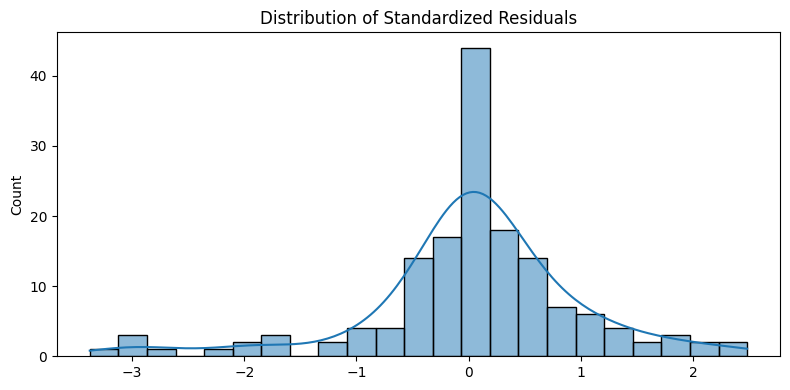

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8, 4))
sns.histplot(resid, kde=True, ax=ax2)
ax2.set_title('Distribution of Standardized Residuals')
plt.tight_layout()
plt.show()

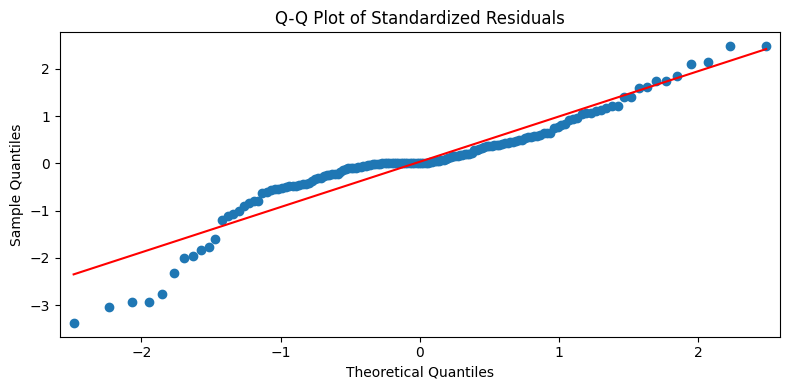

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 4))
sm.qqplot(resid, line='s', ax=ax3)
ax3.set_title('Q-Q Plot of Standardized Residuals')
plt.tight_layout()
plt.show()

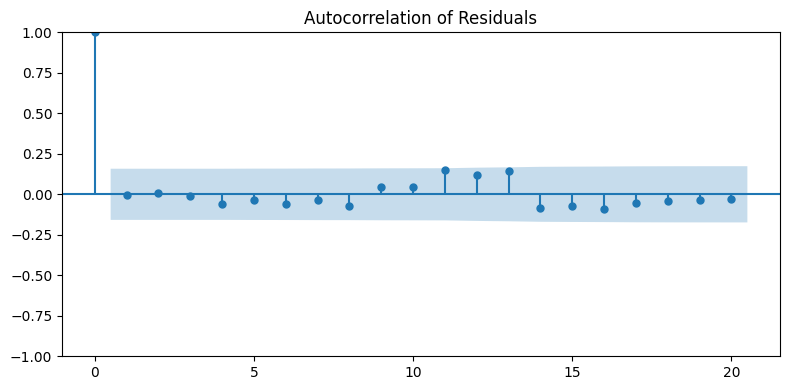

In [ ]:
fig4, ax4 = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax4)
ax4.set_title('Autocorrelation of Residuals')
plt.tight_layout()
plt.show()

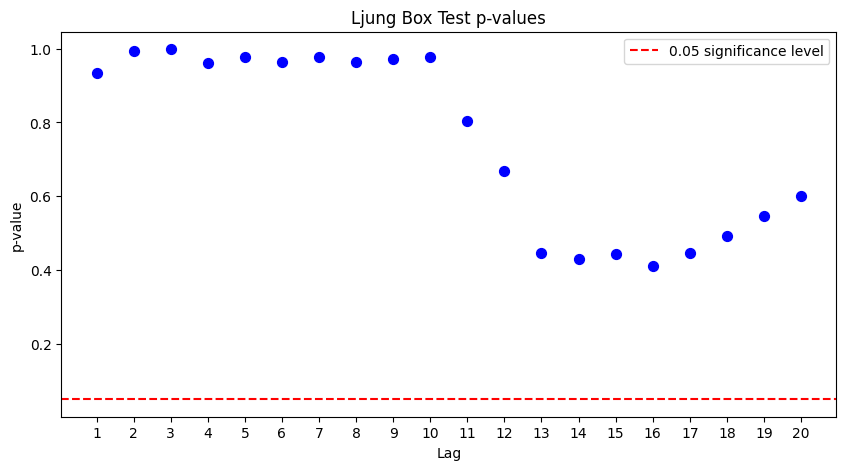

In [ ]:
lb_test = acorr_ljungbox(resid, lags=20, return_df=True)
lags = np.arange(1, 21)
plt.figure(figsize=(10, 5))
plt.scatter(lags, lb_test['lb_pvalue'].values, color='blue', s=50)
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung Box Test p-values')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.xticks(lags)
plt.legend()
plt.show()

In [ ]:
print(lb_test['lb_pvalue'])

1     0.935359
2     0.994213
3     0.998455
4     0.962250
5     0.976132
6     0.963477
7     0.977784
8     0.962569
9     0.970810
10    0.976258
11    0.804547
12    0.669372
13    0.446756
14    0.431262
15    0.442936
16    0.411577
17    0.446407
18    0.492954
19    0.545915
20    0.600153
Name: lb_pvalue, dtype: float64


In [ ]:
shap_stat, shap_p = shapiro(resid)
print(f"Shapiro-Wilk test: W = {shap_stat:}, p-value = {shap_p:}")

if shap_p > 0.05:
    print("Evidence suggests that the samples are normally distributed")
else:
    print("The samples are not normally distributed")

Shapiro-Wilk test: W = 0.9104301739935857, p-value = 3.886311323477132e-08
The samples are not normally distributed


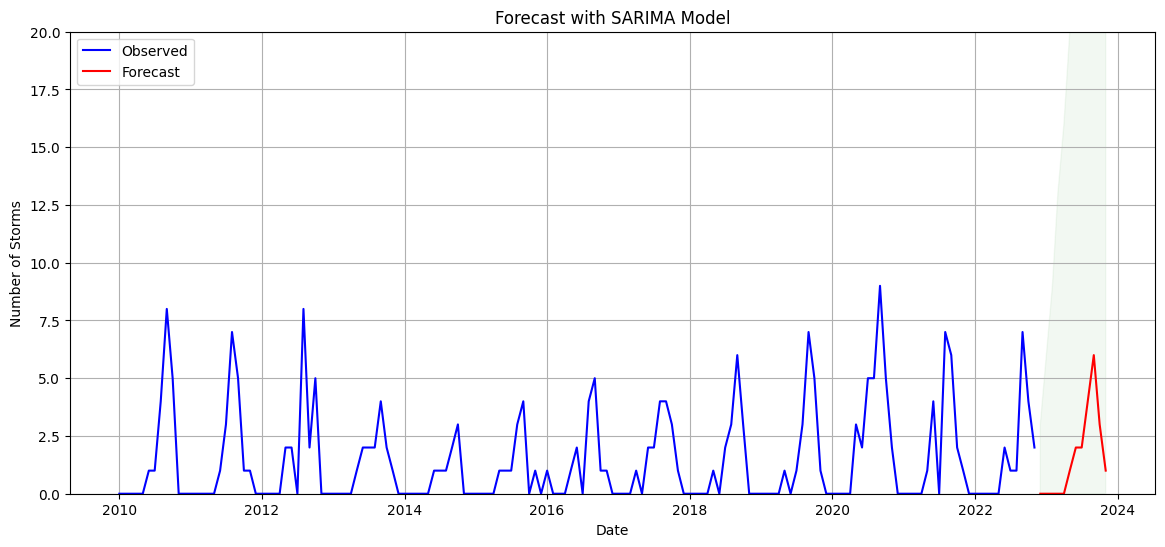

In [ ]:
series = df_monthly_counts['Storm Count']
n_forecast = 12
forecast = results_sarima.get_forecast(steps=n_forecast)
forecast_diff = forecast.predicted_mean
conf_int = forecast.conf_int()
last_observed = series.iloc[-1]
forecast_values = forecast_diff.cumsum() + last_observed
conf_int.iloc[:, 0] = conf_int.iloc[:, 0].cumsum() + last_observed
conf_int.iloc[:, 1] = conf_int.iloc[:, 1].cumsum() + last_observed
forecast_values = forecast_values.clip(lower=0).round()
conf_int.iloc[:, 0] = conf_int.iloc[:, 0].clip(lower=0).round()
conf_int.iloc[:, 1] = conf_int.iloc[:, 1].clip(lower=0).round()
plt.figure(figsize=(14, 6))
plt.plot(series, label="Observed", color="blue")
plt.plot(forecast_values, label="Forecast", color="red")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="green", alpha=0.05)
plt.title("Forecast with SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Number of Storms")
plt.legend()
plt.grid(True)
plt.ylim(0, 20)
plt.show()

In [ ]:
forecast_summary = pd.concat([forecast_values, conf_int], axis=1)
forecast_summary.columns = ['Forecast', 'Lower Bound', 'Upper Bound']
forecast_summary.index = forecast_summary.index.to_period('M').to_timestamp('M')
print(forecast_summary)

            Forecast  Lower Bound  Upper Bound
2022-12-31       0.0          0.0          3.0
2023-01-31       0.0          0.0          6.0
2023-02-28       0.0          0.0          9.0
2023-03-31       0.0          0.0         13.0
2023-04-30       0.0          0.0         16.0
2023-05-31       1.0          0.0         20.0
2023-06-30       2.0          0.0         25.0
2023-07-31       2.0          0.0         28.0
2023-08-31       4.0          0.0         34.0
2023-09-30       6.0          0.0         39.0
2023-10-31       3.0          0.0         40.0
2023-11-30       1.0          0.0         41.0
